# Generatig Emojis with a Diffusion Model

In this project I have developed a basic Diffusion Model and trained it on emojis to generate new ones from random noise.

The things I covered:
1. Intuition behind Diffusion Models
2. Math - Forward process explained in detail, Backward process explained in detail and Derivation of the loss function
3. Implementing the forward process
4. Implementing the Diffusion Model (Unet architecture)
5. Preparing the dataset
6. Sampling an image (Backward process)
7. Training loop
8. Generating new images

# Intuition behind Diffusion Models

**Main idea** - *The essential idea is to systematically and slowly destroy structure in a data distribution through an iterative forward diffusion process. We then learn a reverse diffusion process that restores structure in data, yielding a highly flexible and tractable generative model of the data.*

### Forward Diffusion Process

Applying Gaussian noise to the image from the dataset a lot of times until we are left with pure noise.

$$x_0 \rightarrow x_1 \rightarrow ... \rightarrow x_T $$

The image converges to noise which follows the normal distribution.



### Reverse Diffusion Process

Applying a de-noising step to random noise a lot of times until we get an image similar to something from our dataset.

$$x_T=random\_noise \rightarrow x_{T-1}=model(x_T) \rightarrow ... \rightarrow x_0=model(x_1)

The model learns to predict the noise of images

# Math

Notation:
- $x_t$ - Image at timestep $t\in\{0,...T\}$
- $q(x_t|x_{t-1})$ - One step of the forward process
- $p(x_{t-1}|x_t)$ - One step of the reverse process
- $\mathcal{N}(output; mean, variance)$ - Normal distribution
- $\beta_t$ - a parameter changing with a schedule (linear or cosine)

**Forward process:**

$q(x_t|x_{t-1}) = \mathcal{N}(x_t, \sqrt{1-\beta_t}x_{t-1}, \beta_tI)$

$q(x_t|x_{t-1}) = \sqrt{1-\beta_t}x_{t-1} + \sqrt{\beta_t}\epsilon; \hspace{0.3cm} \epsilon \sim \mathcal{N}(0, 1)$

$\alpha_t=1-\beta_t; \hspace{0.3cm} \overline{\alpha}_t=\prod_{s=1}^{t}\alpha_s$

$q(x_t|x_{t-1}) = \sqrt{\alpha_t}x_{t-1} + \sqrt{1-\alpha_t}\epsilon$

$q(x_t|x_{t-2}) = \sqrt{\alpha_t\alpha_{t-1}}x_{t-2} + \sqrt{1-\alpha_t\alpha_{t-1}}\epsilon$

$...$

$q(x_t|x_{0}) = \sqrt{\overline{\alpha}_t}x_0 + \sqrt{1-\overline{\alpha}_t}\epsilon$

$q(x_t|x_0) = \mathcal{N}(x_t, \sqrt{\overline{\alpha}_t}x_0, (1-\overline{\alpha}_t)I)$

**Reverse Process**

$p(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \sum_\theta(x_t, t))$

- $\sum_\theta(x_t, t)$ will just be a constant, not a learnable function

**Loss function** - Negative log likelyhood: $-log(p_\theta(x_0))$
- We want to use the Negative log likelyhood as the loss function, but the probability of $x_0$ is not easy to compute since we would need all the previous steps to do so.
- *Solution* - Variational Lower Bound
$$- \log(p_{\theta}(x_0)) \leq -\log(p_{\theta}(x_0)) + D_{KL}(q(x_{1:T} | x_0) \| p_{\theta}(x_{1:T} | x_0))$$

**Kullback-Leibler** (KL) divergence: $D_{KL}(P \parallel Q) = \int P(x) \log\left(\frac{P(x)}{Q(x)}\right) \, dx = \mathbb{E}_{x \sim P(x)} \left[ \log \left( \frac{P(x)}{Q(x)} \right) \right]$. This is a measure of how similar two distributions are and the value is always non-negative.

$$- \log(p_{\theta}(x_0)) \leq - \log p_{\theta}(x_0) + \mathbb{E}_{x_{1:T} \sim q(x_{1:T} | x_0)} \left[ \log \left( \frac{q(x_{1:T} | x_0)}{p_{\theta}(x_{1:T} | x_0)} \right) \right]$$

Applying Bayes' rule to the $p_{\theta}(x_{1:T} | x_0)$ term:

$$p_{\theta}(x_{1:T} | x_0) = \frac{p_{\theta}(x_0 | x_{1:T}) p_{\theta}(x_{1:T})}{p_{\theta}(x_0)} = \frac{p_{\theta}(x_0, x_{1:T})}{p_{\theta}(x_0)} = \frac{p_{\theta}(x_{0:T})}{p_{\theta}(x_0)}$$

Taking the result back to the log:

$$\log \left( \frac{q(x_{1:T} | x_0)}{p_{\theta}(x_{1:T} | x_0)} \right) = \log \left( \frac{q(x_{1:T} | x_0)}{\frac{p_{\theta}(x_0, x_{1:T})}{p_{\theta}(x_0)}} \right) = \log \left( \frac{q(x_{1:T} | x_0)}{p_{\theta}(x_{0:T})} \right) + \log(p_{\theta}(x_0))$$

Substituting the last result back into the inequality:

$$- \log(p{\theta}(x_0)) \leq \mathbb{E}_{x_{1:T} \sim q(x_{1:T} | x_0)} \left[ \log \left( \frac{q(x_{1:T} | x_0)}{p_{\theta}(x_{0:T})} \right) + \log(p_{\theta}(x_0)) \right]$$

Using the fact that $p_{\theta}(x_{0:T})$ is independant of the expected value $\mathbb{E}_{x_{1:T} \sim q(x_{1:T} | x_0)}$:

$$\mathbb{E}_{x_{1:T} \sim q(x_{1:T} | x_0)} \left[ \log \left( \frac{q(x_{1:T} | x_0)}{p_{\theta}(x_{0:T})} \right) + \log(p_{\theta}(x_0)) \right] = \mathbb{E}_{x_{1:T} \sim q(x_{1:T} | x_0)} \left[ \log \left( \frac{q(x_{1:T} | x_0)}{p_{\theta}(x_{0:T})} \right) \right] + \log(p_{\theta}(x_0))$$

The two same terms of the inequality cancel out and we add the expected value to the left hand side since it doesn't affect its value:

$$\mathbb{E}_{x_{1:T} \sim q(x_{1:T} | x_0)} [- \log(p{\theta}(x_0))] \leq \mathbb{E}_{x_{1:T} \sim q(x_{1:T} | x_0)} \left[ \log \left( \frac{q(x{1:T} | x_0)}{p_{\theta}(x_{0:T})} \right) \right]$$

On the right-hand side, the denominator is the forwarding process starting from $x_0$, and the numerator is the reverse process:

$$\log \left( \frac{q(x_{1:T} | x_0)}{p_{\theta}(x_{0:T})} \right) = \log \left( \frac{\prod_{t=1}^{T} q(x_t | x_{t-1})}{p_{\theta}(x_T) \prod_{t=1}^{T} p_{\theta}(x_{t-1} | x_t)} \right) = - \log p_{\theta}(x_T) + \sum_{t=1}^{T} \log \left( \frac{q(x_t | x_{t-1})}{p_{\theta}(x_{t-1} | x_t)} \right)$$

Now we will take the first element of the sum outside:

$$- \log p_{\theta}(x_T) + \sum_{t=1}^{T} \log \left( \frac{q(x_t | x_{t-1})}{p_{\theta}(x_{t-1} | x_t)} \right) = - \log p_{\theta}(x_T) + \sum_{t=2}^{T} \log \left( \frac{q(x_t | x_{t-1})}{p_{\theta}(x_{t-1} | x_t)} \right) + \log \left( \frac{q(x_1 | x_0)}{p_{\theta}(x_0 | x_1)} \right)$$

Applying Bayers' rule to the numerator in the sum:

$$q(x_t | x_{t-1}) = \frac{q(x_{t-1} | x_t) q(x_t)}{q(x_{t-1})}$$

The problem is that this has high variance, we solve that by conditioning on $x_0$ which does not affect the value of the expression due to the properties of Markov chains ($x_t$ is only dependant on $x_{t-1}$).

$$\frac{q(x_{t-1} | x_t) q(x_t)}{q(x_{t-1})} = \frac{q(x_{t-1} | x_t, x_0) q(x_t | x_0)}{q(x_{t-1} | x_0)}$$

Putting this back in the original equation:

$$- \log p_{\theta}(x_T) + \sum_{t=2}^{T} \log \left( \frac{q(x_t | x_{t-1})}{p_{\theta}(x_{t-1} | x_t)} \right) + \log \left( \frac{q(x_1 | x_0)}{p_{\theta}(x_0 | x_1)} \right) = - \log p_{\theta}(x_T) + \sum_{t=2}^{T} \log \left( \frac{q(x_{t-1} | x_t, x_0) q(x_t | x_0)}{p_{\theta}(x_{t-1} | x_t) q(x_{t-1} | x_0)} \right) + \log \left( \frac{q(x_1 | x_0)}{p_{\theta}(x_0 | x_1)} \right) $$

Splitting the sum:

$$\sum_{t=2}^{T} \log \left( \frac{q(x_{t-1} | x_t, x_0) q(x_t | x_0)}{p_{\theta}(x_{t-1} | x_t) q(x_{t-1} | x_0)} \right)
=
\sum_{t=2}^{T} \log \left( \frac{q(x_{t-1} | x_t, x_0)}{p_{\theta}(x_{t-1} | x_t)} \right) + \sum_{t=2}^{T} \log \left( \frac{q(x_t | x_0)}{q(x_{t-1} | x_0)} \right)$$

Taking a look at the second summation from above, it simplifies down do this:

$$\frac{q(x_2 | x_0) q(x_3 | x_0) \cdots q(x_{T-1} | x_0) q(x_T | x_0)}{q(x_1 | x_0) q(x_2 | x_0) \cdots q(x_{T-2} | x_0) q(x_{T-1} | x_0)} = \frac{q(x_T | x_0)}{q(x_1 | x_0)}$$

Using this in the previous equation gets us:

$$\sum_{t=2}^{T} \log \left( \frac{q(x_{t-1} | x_t, x_0) q(x_t | x_0)}{p_{\theta}(x_{t-1} | x_t) q(x_{t-1} | x_0)} \right)
=
\sum_{t=2}^{T} \log \left( \frac{q(x_{t-1} | x_t, x_0)}{p_{\theta}(x_{t-1} | x_t)} \right) + \log \left( \frac{q(x_T | x_0)}{q(x_1 | x_0)} \right)$$

Substituting this back:

$$- \log p_{\theta}(x_T) + \sum_{t=2}^{T} \log \left( \frac{q(x_{t-1} | x_t, x_0) q(x_t | x_0)}{p_{\theta}(x_{t-1} | x_t) q(x_{t-1} | x_0)} \right) + \log \left( \frac{q(x_1 | x_0)}{p_{\theta}(x_0 | x_1)} \right)$$
$$= - \log p_{\theta}(x_T) + \sum_{t=2}^{T} \log \left( \frac{q(x_{t-1} | x_t, x_0)}{p_{\theta}(x_{t-1} | x_t)} \right) + \log \left( \frac{q(x_T | x_0)}{q(x_1 | x_0)} \right) + \log \left( \frac{q(x_1 | x_0)}{p_{\theta}(x_0 | x_1)} \right)$$
$$= - \log p_{\theta}(x_T) + \sum_{t=2}^{T} \log \left( \frac{q(x_{t-1} | x_t, x_0)}{p_{\theta}(x_{t-1} | x_t)} \right) + \log \left( \frac{q(x_T | x_0) q(x_1 | x_0)}{q(x_1 | x_0) p_{\theta}(x_0 | x_1)} \right)$$
$$= \log q(x_T | x_0) - \log p_{\theta}(x_T) + \sum_{t=2}^{T} \log \left( \frac{q(x_{t-1} | x_t, x_0)}{p_{\theta}(x_{t-1} | x_t)} \right) - \log p_{\theta}(x_0 | x_1)$$
$$= \log \left( \frac{q(x_T | x_0)}{p_{\theta}(x_T)} \right) + \sum_{t=2}^{T} \log \left( \frac{q(x_{t-1} | x_t, x_0)}{p_{\theta}(x_{t-1} | x_t)} \right) - \log p_{\theta}(x_0 | x_1)$$

We use this back in the right hand side of the inequality for the lower bound. On the right side because we are calculating the expected value of the log ratios and by definition that is exactly the KL divergence of two distributions. We get this:

$$\mathbb{E}_{x_{1:T} \sim q(x_{1:T} | x_0)} \left[ \log \frac{q(x_{1:T} | x_0)}{p_{\theta}(x_{0:T})} \right] = \underbrace{D_{KL}(q(x_T | x_0) \parallel p_{\theta}(x_T))}_{L_T} + \sum_{t=2}^{T} \underbrace{D_{KL}(q(x_{t-1} | x_t, x_0) \parallel p_{\theta}(x_{t-1} | x_t))}_{L_{t-1}} - \underbrace{\log p_{\theta}(x_0 | x_1)}_{L_0}$$

$L_T$ componenet can be ignored since q has no learnable parameters and $x_T$ is just Gaussian noise.

We will take a look at the $L_t$ component. It calculates the KL divergence between $q$ and $p$. We already know the following:
$p_{\theta}(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_{\theta}(x_t, t), \sigma_t \mathbf{I})$ (the variance is fixed). 
We can also write $q$ like this:
$q(x_{t-1} | x_t, x_0) = \mathcal{N}(x_{t-1}; \tilde{\mu}_{\theta}(x_t, x_0), \tilde{\beta}_t \mathbf{I})$

Applying the Bayers' rule results in the following:
$$q(x_{t-1} | x_t, x_0) = q(x_t | x_{t-1}, x_0) \frac{q(x_{t-1} | x_0)}{q(x_t | x_0)}$$

Let's remind ourselves of the general structure of a Gaussian distribution:

$$ \mathcal{N}(x) \propto \exp \left( -\frac{1}{2} \frac{(x - \mu)^2}{\sigma^2} \right) = \exp \left( -\frac{1}{2} \frac{x^2 - 2 \mu x + \mu^2}{\sigma^2} \right) = \exp \left( -\frac{1}{2} \left[ \frac{1}{\sigma^2}x^2 - \frac{2 \mu}{\sigma^2}x + \frac{\mu^2}{\sigma^2} \right] \right) $$

All of the distributions from before are Gaussian, we will use this:
- $ q(x_t | x_{t-1}, x_0) $: mean = $ \sqrt{\alpha_t} x_{t-1} $; variance = $ \beta_t $
- $ q(x_{t-1} | x_0) $: mean = $ \sqrt{\overline{\alpha}_{t-1}} x_0 $; variance: $ \sqrt{1-\overline{\alpha}_{t-1}} $
- $ q(x_{t} | x_0) $: mean = $ \sqrt{\overline{\alpha}_t} x_0 $; variance: $ \sqrt{1-\overline{\alpha}_t} $

Now we can combine their quadratic forms in the exponents and get this:

$$q(x_{t-1} | x_t, x_0) \propto \exp \left( -\frac{1}{2} \left[ \frac{(x_t - \sqrt{\alpha_t} x_{t-1})^2}{\beta_t} + \frac{(x_{t-1} - \sqrt{\alpha_{t-1}} x_0)^2}{1 - \tilde{\alpha}_{t-1}} - \frac{(x_t - \sqrt{\alpha_t} x_0)^2}{1 - \tilde{\alpha}_t} \right] \right)$$

Rearranging the terms to get a Gaussian structure results in the following:

$$ q(x_{t-1} | x_t, x_0) \propto \exp \left( -\frac{1}{2} \left[ \underbrace{\left( \frac{\alpha_t}{\beta_t} + \frac{1}{1 - \bar{\alpha}_{t-1}} \right)}_{1/\sigma^2} x_{t-1}^2 - \underbrace{\left( \frac{2 \sqrt{\alpha_t}}{\beta_t} x_t + \frac{2 \sqrt{\bar{\alpha}_{t-1}}}{1 - \bar{\alpha}_{t-1}} x_0 \right)}_{2\mu/\sigma^2} x_{t-1} + \underbrace{f(x_t, x_0)}_{\mu^2/\sigma^2} \right] \right) $$

$f$ is some function of $x_t$ and $x_0$ which we do not need to find the mean and variance.

From the first term, we get:

$$ \sigma^2 = \tilde{\beta}_t = \frac{1}{\left( \frac{\alpha_t}{\beta_t} + \frac{1}{1 - \bar{\alpha}_{t-1}} \right)} = \frac{1}{\left( \frac{\alpha_t - \bar{\alpha}_t + \beta_t}{\beta_t(1 - \bar{\alpha}_{t-1})} \right)} = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t $$

From the second term and the result for variance we get:

$$ \tilde{\mu}_t(x_t, x_0) = \left( \frac{\sqrt{\alpha_t}}{\beta_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}}{1 - \bar{\alpha}_{t-1}} x_0 \right) \frac{1}{\left( \frac{\alpha_t}{\beta_t} + \frac{1}{1 - \bar{\alpha}_{t-1}} \right)} 
= \left( \frac{\sqrt{\alpha_t}}{\beta_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}}{1 - \bar{\alpha}_{t-1}} x_0 \right) \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t 
= \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1 - \bar{\alpha}_t} x_0 $$

From the definitions in the beginning we can derive the following:

$$ \mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon
\Rightarrow \mathbf{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( \mathbf{x}_t - \sqrt{1 - \bar{\alpha}_t} \epsilon \right) $$

Substituting this into the previous equation gives us:

$$ \tilde{\mu}_t(\mathbf{x}_t, \mathbf{x}_0) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon \right) $$

If we look at the loss function we derived earlier, we see that $\mu_\theta$ should be trained to predict $\tilde{\mu_t}$. Since we already know $x_t$ in the reverse process, we only need to predict the noise at step $t$, that being $\epsilon_t$. We can write $\epsilon_t$ to be a function of $x_t$ and $t$, dependant on the trainable parameters of the neural network:

$$ \mu_{\theta}(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_{\theta}(\mathbf{x}_t, t) \right) $$

Since we deal with Gaussians and the only parameter is the mean, using the KL divergence leads to the following loss:

$$ L_t = \frac{1}{2 \sigma_t^2} \left\lVert \tilde{\mu}_t(\mathbf{x}_t, \mathbf{x}_0) - \mu_{\theta}(\mathbf{x}_t, t) \right\rVert^2 $$
$$ L_t = \frac{1}{2 \sigma_t^2} \left\lVert \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_t \right) - \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_{\theta}(\mathbf{x}_t, t) \right) \right\rVert^2 $$
$$ L_t = \frac{(1 - \alpha_t)^2}{2 \alpha_t (1 - \bar{\alpha}_t) \sigma_t^2} \left\lVert \epsilon_t - \epsilon_{\theta}(\mathbf{x}_t, t) \right\rVert^2 $$

In the [DDPM](https://arxiv.org/abs/2006.11239) paper, it is found empirically that the training works better if the scaling factor is omitted, therefore, we can simplify the loss to:

$$ L_t = \left\lVert \epsilon_t - \epsilon_{\theta}(\mathbf{x}_t, t) \right\rVert^2 $$

We still have to handle the $L_0$ term in the loss function. The DDPM paper suggests using an independent discrete decoder derived from the Gaussian $ \mathcal{N}(\mathbf{x}_0; \mu_{\theta}(\mathbf{x}_1, 1)\sigma^2 \mathbf{I}) $

The paper also assumes that the image is originally constructed from discrete pixels with values {0, 1, 2, …, 255} that scaled to the range [-1, 1]. The distribution is then represented as:

$$ p_{\theta}(\mathbf{x}_0 | \mathbf{x}_1) = \prod_{i=1}^{D} \int_{\delta_-(x_0^i)}^{\delta_+(x_0^i)} \mathcal{N}(x, \mu_{\theta}^i(\mathbf{x}_1, 1), \sigma_1^2) dx $$

where:

$$
\delta_+(x) =
\begin{cases}
    \infty & \text{if } x = 1 \\
    x + \frac{1}{255} & \text{if } x < 1
\end{cases}
\quad
\delta_-(x) =
\begin{cases}
    -\infty & \text{if } x = -1 \\
    x - \frac{1}{255} & \text{if } x > -1
\end{cases}
$$

However, the paper simplifies this loss also. Instead of calculating the integral, it is approximated by the Gaussian probability density function times the bin width:

$$ p_{\theta}(\mathbf{x}_0 | \mathbf{x}_1) \approx \frac{1}{\sqrt{2 \pi \sigma_1}} \exp\left( -\frac{1}{2} \frac{\left\lVert \mathbf{x}_0 - \mu_{\theta}(\mathbf{x}_1, 1) \right\rVert^2}{\sigma_1^2} \right) \cdot \frac{2}{255} $$

and the log will be:

$$ L_0 = - \log(p_{\theta}(\mathbf{x}_0 | \mathbf{x}_1)) \approx \frac{1}{2 \sigma_1^2} \left\lVert \mathbf{x}_0 - \mu_{\theta}(\mathbf{x}_1, 1) \right\rVert^2 + C $$

$C$ is a constant we can ignore for the loss function since it is not trainable.

The same formula from before holds for $\mu_{\theta}(\mathbf{x}_1, 1)$:

$$ \mu_{\theta}(\mathbf{x}_1, 1) = \frac{1}{\sqrt{\alpha_1}} \left( \mathbf{x}_1 - \frac{1 - \alpha_1}{\sqrt{1 - \bar{\alpha}_1}} \epsilon_{\theta}(\mathbf{x}_1, 1) \right) $$

Substituting this in for $L_0$ and ignoring the scaling factors:

$$ L_0 \approx \left\lVert \epsilon_1 - \epsilon_{\theta}(\mathbf{x}_1, 1) \right\rVert^2 $$

### Simplified Training Objective

The loss that will be used:

$$ L_{\text{simple}} := \mathbb{E}_{t \sim U[1, T], \mathbf{x}_0, \epsilon} \left[ \left\lVert \epsilon - \epsilon_{\theta}(\mathbf{x}_t, t) \right\rVert^2 \right] $$
$$ L_{\text{simple}} = \mathbb{E}_{t \sim U[1, T], \mathbf{x}_0, \epsilon} \left[ \left\lVert \epsilon - \epsilon_{\theta} \left( \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, t \right) \right\rVert^2 \right] $$

Training process:
1. **Repeat**
2. $\mathbf{x}_0 \sim q(\mathbf{x}_0)$
3. $t \sim \text{Uniform}(\{1, \dots, T\})$
4. $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
5. Take gradient descent step on: $ \nabla_{\theta} \left\lVert \epsilon - \epsilon_{\theta} \left( \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, t \right) \right\rVert^2 $
6. **Until** converged

# Preparation for implenenting the model

In [87]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("mps" if torch.backends.mps.is_available() else "cpu")

mps


# Implementing the Forward Process

### Variance Schedule

1. Linear schedule - This was used in the initial paper about denoising diffusion probabilistic models.
2. Cosine schedule - This was later used in a subsequent paper ([*Improved Denoising Diffusion Probabilistic Models*](https://arxiv.org/abs/2102.09672)) and it has been shown to produce better results because information is lost more slowly than with the linear schedule. 

In [88]:
def linear_schedule(num_timesteps):
  beta_start = 1e-4
  beta_end = 0.02
  betas = torch.linspace(beta_start, beta_end, num_timesteps)
  return betas

def cosine_schedule(num_timesteps, s=0.008):
  def f(t):
    return torch.cos((t / num_timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2
  x = torch.linspace(0, num_timesteps, num_timesteps + 1)
  alphas_cumprod = f(x) / f(torch.tensor([0]))
  betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
  betas = torch.clip(betas, 0.0001, 0.999)
  return betas

Now, we want to define a function for sampling from the forward process. First, let’s define a helper function to sample a tensor sorted by time, according to timesteps:

In [89]:
def sample_by_t(tensor_to_sample, timesteps, x_shape):
  batch_size = timesteps.shape[0]
  sampled_tensor = tensor_to_sample.gather(-1, timesteps.cpu())
  sampled_tensor = torch.reshape(sampled_tensor, (batch_size,) + (1,) * (len(x_shape) - 1))
  return sampled_tensor.to(timesteps.device)

Define αₜ, α̅ₜ, βₜ and some operation on them

In [179]:
num_timesteps = 500
betas_t = linear_schedule(num_timesteps)

alphas_t = 1. - betas_t
alphas_bar_t = torch.cumprod(alphas_t, dim=0)
alphas_bar_t_minus_1 = torch.cat((torch.tensor([0]), alphas_bar_t[:-1]))
one_over_sqrt_alphas_t = 1. / torch.sqrt(alphas_t)
sqrt_alphas_bar_t = torch.sqrt(alphas_bar_t)
sqrt_1_minus_alphas_bar_t = torch.sqrt(1. - alphas_bar_t)

# the variance of q(xₜ₋₁ | xₜ, x₀)
posterior_variance = (1. - alphas_bar_t_minus_1) / (1. - alphas_bar_t) * betas_t

The forward process sampling function:

In [91]:
def sample_q(x0, t, noise=None):
  if noise is None:
    noise = torch.randn_like(x0)

  t = t.long()

  sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t, t, x0.shape)
  sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t, t, x0.shape)

  xt = sqrt_alphas_bar_t_sampled * x0 + sqrt_1_minus_alphas_bar_t_sampled * noise

  # clipping the values in range [-1, 1]
  xt = torch.clamp(xt, -1, 1)
  return xt

Loading a random image from the interenet.

In [187]:
import requests
from PIL import Image

url = 'https://images.pexels.com/photos/1557208/pexels-photo-1557208.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2'
image_raw_data = requests.get(url, stream=True).raw
image = Image.open(image_raw_data)

Transforming the image into a torch tensor

In [188]:
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize, Normalize, RandomHorizontalFlip

image_size = 32
transform = Compose([
  Resize(image_size),  # resize smaller edge to image_size
  CenterCrop(image_size),  # make a square image with size image_size
  RandomHorizontalFlip(), # flip the image horizontally with a probability of 0.5
  ToTensor(),  # convert to tensor with shape CHW and values in the range [0, 1]
  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # set the values to the range [-1, 1]
])

x0 = transform(image).unsqueeze(0)
print(x0.shape)

torch.Size([1, 3, 32, 32])


Reverse transformation to return the image into a PIL object and one for getting a tensor with values in the range [0, 1].

In [189]:
from torchvision.transforms import ToPILImage

reverse_transform_pil = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
  ToPILImage()
])

reverse_transform_tensor = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
])

Function that, given an image as a tensor and a timestep t, returns a noisy image sampled from the q distribution.

In [190]:
def get_noisy_image(x0, t, transform=reverse_transform_pil):
  x_noisy = sample_q(x0, t)
  noise_image = transform(x_noisy.squeeze())
  return noise_image

Function for displaying the image.

In [191]:
import matplotlib.pyplot as plt
def show_noisy_images(noisy_images):
    """
    Show and return a grid of noisy images where
    the rows are different images, and the columns
    are the noisy images in different timesteps.

    Args:
    noisy_images (list[list[PIL]]): a list with a lists of images
        with noise from different timesteps.
    """
    num_of_image_sets = len(noisy_images)
    num_of_images_in_set = len(noisy_images[0])
    image_size = noisy_images[0][0].size[0]

    full_image = Image.new('RGB', (image_size * num_of_images_in_set + (num_of_images_in_set - 1), image_size * num_of_image_sets + (num_of_image_sets - 1)))
    for set_index, image_set in enumerate(noisy_images):
        for image_index, image in enumerate(image_set):
            full_image.paste(image, (image_index * image_size + image_index, set_index * image_size + set_index))
    
    plt.imshow(full_image)
    plt.axis('off')
    return full_image

See an exaple:

torch.Size([1, 3, 32, 32])


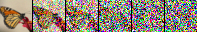

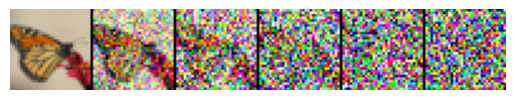

In [193]:
print(x0.shape)
show_noisy_images([[get_noisy_image(x0, torch.tensor([t])) for t in [0, 100, 200, 300, 400, 499]]])

# Implementing the Diffusion Model (Unet architecture)

We will use the Unet architecture

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*W-RkwGIiKDF3A3WXwZQMWg.png" alt="drawing" width="400"/>


### Architecture of the U-net

Input: (32, 32, 3)

Encoder:
- Conv (3x3, filters=64), BatchNorm, ReLU
- MaxPool (2x2)
- Conv (3x3, filters=128), BatchNorm, ReLU
- MaxPool (2x2)

Bottleneck:
- Conv (3x3, filters=256), BatchNorm, ReLU

Decoder:
- UpConv (transpose conv) or Bilinear Upsampling
- Conv (3x3, filters=128), BatchNorm, ReLU
- UpConv (transpose conv) or Bilinear Upsampling
- Conv (3x3, filters=64), BatchNorm, ReLU

Output:
- Conv (1x1, filters=3), Sigmoid (for pixel values in [0,1])

In [98]:
class UNetModel(nn.Module):
    def __init__(self):
        super(UNetModel, self).__init__()

        # Time embedding layers
        self.time_mlp = nn.Sequential(
            nn.Linear(1, 128),
            nn.GELU(),
            nn.Linear(128, 256),
            nn.GELU()
        )

        # down layers - encoder
        self.encoderConv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.encoderConv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # bottleneck layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # up layers - decoder (with residual connections)
        self.upConv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)
        self.decoderConv1 = nn.Sequential(
            nn.Conv2d(128*2, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upConv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)
        self.decoderConv2 = nn.Sequential(
            nn.Conv2d(64*2, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # output layer generates the predicted noise (added a residual connection to the output, therefore adding three input channels)
        self.output = nn.Conv2d(64+3, 3, kernel_size=1, stride=1, padding=0)


    def forward(self, x, time):
        # Embed time
        time = time.float()
        t_embed = self.time_mlp(time.unsqueeze(-1))

        # encoder
        x_down1 = self.encoderConv1(x)  # 3x32x32 -> 64x32x32
        x_down2 = self.encoderConv2(self.pool(x_down1))  # 64x16x16 -> 128x16x16

        # bottleneck
        bottleneck = self.bottleneck(self.pool(x_down2))  # 128x8x8 -> 256x8x8

        # Add time embedding to bottleneck features
        # bottleneck = bottleneck + t_embed.view(t_embed.size(0), -1, 1, 1)

        # decoder
        x_up1 = self.upConv1(bottleneck)
        x_concat1 = torch.cat((x_up1, x_down2), dim=1)
        x_upResult1 = self.decoderConv1(x_concat1)
        x_up2 = self.upConv2(x_upResult1)
        x_concat2 = torch.cat((x_up2, x_down1), dim=1)
        x_upResult2 = self.decoderConv2(x_concat2)

        # output
        x_concat3 = torch.cat((x_upResult2, x), dim=1)
        output = self.output(x_concat3)

        return output

# Preparing the Dataset

We are going to load the dataset consisted of the face-like emojis from the Apple folder in the [Full Emoji Dataset](https://www.kaggle.com/datasets/subinium/emojiimage-dataset). We do not need any labels for the images, since we are training a simple diffusion model without any additional conditioning.

torch.Size([1, 3, 32, 32])


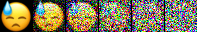

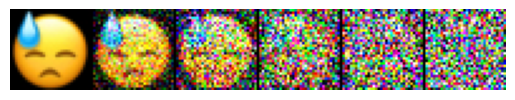

In [99]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_filenames = os.listdir(image_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_filenames[idx])
        
        # Open the image with RGBA mode
        image = Image.open(img_path).convert('RGBA')

        # Create a black background image of the same size
        black_background = Image.new("RGBA", image.size, (0, 0, 0, 255))

        # Composite the original image on top of the black background
        composite_image = Image.alpha_composite(black_background, image)

        # Convert back to RGB, discarding the alpha channel
        image = composite_image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Usage example
image_folder = './Dataset/image/Apple_Faces'
dataset = ImageDataset(image_folder, transform=transform)

# Load the first image
first_image = dataset[0].unsqueeze(0)
first_image = first_image.to(device)
print(first_image.shape)

# print((first_image+1)/2)
# show_noisy_images([[get_noisy_image(first_image, torch.tensor([t])) for t in [0]]])
show_noisy_images([[get_noisy_image(first_image, torch.tensor([t], device=device)) for t in [0, 100, 200, 300, 400, 499]]])

Function which shows the image from a tensor:

In [194]:
def show_tensor_image(image_tensor):
    image_tensor = image_tensor.permute(1, 2, 0)

    # Convert the tensor to a numpy array (bring channels to last dimension)
    image_np = image_tensor.numpy()
    
    # Clip the values to be between 0 and 1 for proper visualization
    image_np = (image_np + 1) / 2
    
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

# show_tensor_image(first_image[0].cpu())

# Sampling an image (Backward process)

Sampling an image is done step by step by removing noise from the initial randomly generated image (x_T). To achieve that, an image is sampled from the distributions $q(x_{t-1}|x_t)$ repeatedly for $t \in [1,...T]$, until $x_0$ is generated.

$$\mu_t(\mathbf{x}_t, \mathbf{x}_0) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \right) = \frac{\sqrt{\bar{\alpha}_{t-1} \beta_t}}{1 - \bar{\alpha}_t} \mathbf{x}_0 + \frac{\sqrt{\alpha_t (1 - \bar{\alpha}_{t-1})}}{1 - \bar{\alpha}_t} \mathbf{x}_t$$

$$ \mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \right) + \sigma_t \mathbf{z} $$

The following program implements the backward noise removal step in the image generation process.

In [147]:
@torch.no_grad()
def sample_p(model, x_t, t, clipping=True):
  """
  Sample from p_θ(xₜ₋₁|xₜ) to get xₜ₋₁ according to the algorithm (as seen below)
  """
  x_t = x_t.cpu()

  t = t.long()
  betas_t_sampled = sample_by_t(betas_t, t, x_t.shape)
  sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t, t, x_t.shape)
  one_over_sqrt_alphas_t_sampled = sample_by_t(one_over_sqrt_alphas_t, t, x_t.shape)

  if clipping:
    sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t, t, x_t.shape)
    sqrt_alphas_bar_t_minus_1_sampled = sample_by_t(torch.sqrt(alphas_bar_t_minus_1), t, x_t.shape)
    alphas_bar_t_sampled = sample_by_t(alphas_bar_t, t, x_t.shape)
    sqrt_alphas_t_sampled = sample_by_t(torch.sqrt(alphas_t), t, x_t.shape)
    alphas_bar_t_minus_1_sampled = sample_by_t(alphas_bar_t_minus_1, t, x_t.shape)

    x0_reconstruct = 1 / sqrt_alphas_bar_t_sampled * (x_t - sqrt_1_minus_alphas_bar_t_sampled * model(x_t, t/num_timesteps))
    x0_reconstruct = torch.clamp(x0_reconstruct, -1., 1.)
    predicted_mean = (sqrt_alphas_bar_t_minus_1_sampled * betas_t_sampled) / (1 - alphas_bar_t_sampled) * x0_reconstruct + (sqrt_alphas_t_sampled * (1 - alphas_bar_t_minus_1_sampled)) /  (1 - alphas_bar_t_sampled) * x_t

  else:
    predicted_mean = one_over_sqrt_alphas_t_sampled * (x_t - betas_t_sampled / sqrt_1_minus_alphas_bar_t_sampled * model(x_t, t/num_timesteps))

  if t[0].item() == 1:
    return predicted_mean
  else:
    posterior_variance_sampled = sample_by_t(posterior_variance, t, x_t.shape)
    noise = torch.randn_like(x_t)
    result = predicted_mean + torch.sqrt(posterior_variance_sampled) * noise
    result = torch.clamp(result, -1., 1.)
    return result

The full algorithm for sampling images is the following:
1. $\mathbf{x}_T \sim \mathcal{N}(0, \mathbf{I})$
2. **for** $t = T, \dots, 1 \text{ do}$
3. $\mathbf{z} \sim \mathcal{N}(0, \mathbf{I}) \text{ if } t > 1, \text{ else } \mathbf{z} = 0$
4. $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \right) + \sigma_t \mathbf{z}$
5. **end for**
6. return $x_0$

Step 4. was implemented in the $sample\_p$ function. 

### Full sampling algorithm implementation:

In [148]:
from tqdm import tqdm
@torch.no_grad()
def sampling(model, shape, image_noise_steps_to_keep=1):
  """
  Implmenting Algorithm 2 - sampling.
  Args:
    model (torch.Module): the model that predictד the noise
    shape (tuple): shape of the data (batch, channels, image_size, image_size)
  Returns:
    (list): list containing the images in the different steps of the reverse process
  """

  batch = shape[0]
  images = torch.randn(shape, device=device)  # pure noise
  images_list = []

  # for timestep in tqdm(range(num_timesteps-1, 0, -1), desc='sampling timestep'):
  for timestep in range(num_timesteps-1, 0, -1):
    images = sample_p(model, images, torch.full((batch,), timestep, dtype=torch.long))
    if timestep <= image_noise_steps_to_keep or True:
      images_list.append(images.cpu())
  return images_list

# Training

### Initializing the model, loss function, optimizer and dataloader.

In [196]:
model = UNetModel().to(device)

def compute_loss(model, x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0).to(device)

    x_t = sample_q(x0, t.int(), noise)
    predicted_noise = model(x_t, t/num_timesteps)
    loss = F.mse_loss(noise, predicted_noise)
    return loss
    

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

BATCH_SIZE = 8
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

### Small tests before tranining

Sampling an image before traning:

tensor([[[0.0180]]], device='mps:0')
tensor([[[0.0160]]], device='mps:0')
tensor([[[0.0140]]], device='mps:0')
tensor([[[0.0120]]], device='mps:0')
tensor([[[0.0100]]], device='mps:0')
tensor([[[0.0080]]], device='mps:0')
tensor([[[0.0060]]], device='mps:0')
tensor([[[0.0040]]], device='mps:0')
tensor([[[0.0020]]], device='mps:0')
499


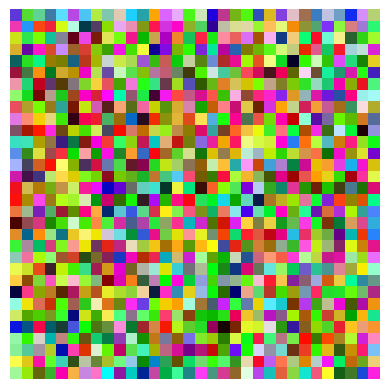

In [106]:
test_result = sampling(model.to(device), first_image.shape)
print(len(test_result))
show_tensor_image(test_result[-1][0])

Running a test to see the noise prediction of the model before training:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2696592..2.0856662].


torch.Size([1, 3, 32, 32])


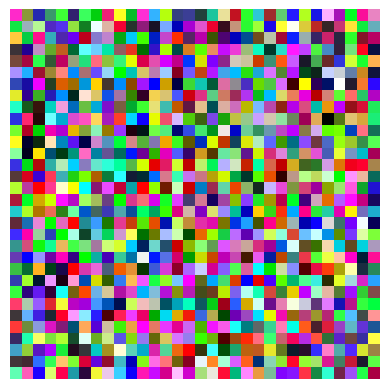

In [198]:
# Testing the model
with torch.no_grad():
    test_output = model(sample_q(first_image.to(device), torch.tensor([100], device=device)), torch.tensor([100./num_timesteps]).to(device))
    print(test_output.shape)
    show_tensor_image(test_output[0].cpu())

### Training loop:

Training process (from the 'math' part):
1. **Repeat**
2. $\mathbf{x}_0 \sim q(\mathbf{x}_0)$
3. $t \sim \text{Uniform}(\{1, \dots, T\})$
4. $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
5. Take gradient descent step on: $ \nabla_{\theta} \left\lVert \epsilon - \epsilon_{\theta} \left( \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, t \right) \right\rVert^2 $
6. **Until** converged

In [197]:
epochs = 500
start_epoch = 0

for epoch in range(start_epoch, epochs):
  for batch_index, batch in enumerate(dataloader):
    images = batch.to(device)
    # sample t according to Algorithm 1
    t = torch.randint(1, num_timesteps, (images.shape[0],), device=device).float()
    loss = compute_loss(model, images, t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch % 50 == 0: print(f"Epoch: {epoch}, loss={loss.item()}")

Epoch: 0, loss=0.28483155369758606
Epoch: 50, loss=0.16741099953651428
Epoch: 100, loss=0.14398488402366638
Epoch: 150, loss=0.12759879231452942
Epoch: 200, loss=0.18476080894470215
Epoch: 250, loss=0.1302875429391861
Epoch: 300, loss=0.11238956451416016
Epoch: 350, loss=0.13773289322853088
Epoch: 400, loss=0.1122124195098877
Epoch: 450, loss=0.10404359549283981


# Generating a few emojis with the model

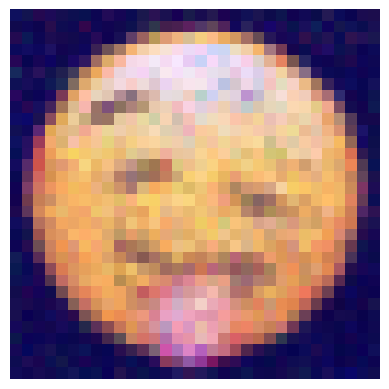

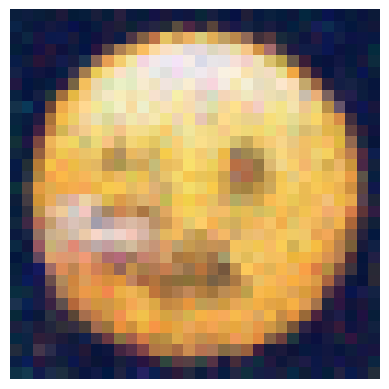

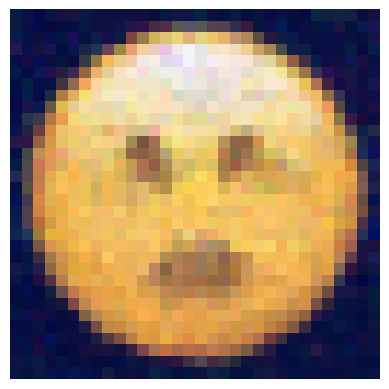

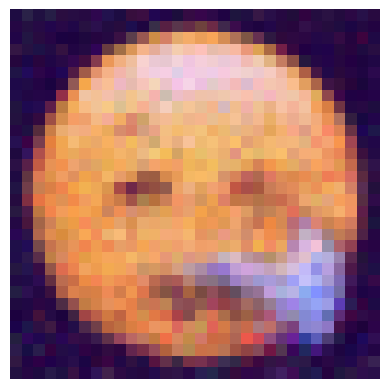

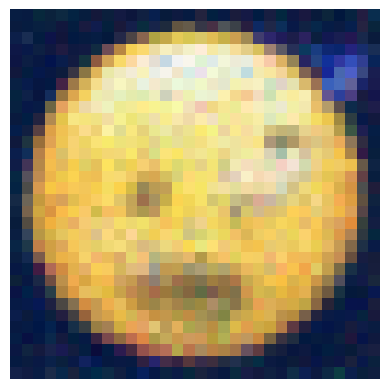

In [178]:
for i in range(5):
    test_result = sampling(model, first_image.shape)

    # get max and min value in the tensor
    max = torch.max(test_result[-1])
    min = torch.min(test_result[-1])

    # scaling the color values range from [min, max] to [-1, 1] linearly
    scaled_image = (test_result[-1] - min) / (max - min) * 2 - 1

    show_tensor_image(scaled_image[0])

# Conclusion

Probabilistic Denoising Diffusion Models are a lot more complex than Autoregressive models, but I would say that it results in better images. This model was able to better learn the patterns and produces results that are more realistic. The only downside I have noticed is its inconcistency with the colors.

Colors are always a little bit off and not as saturated, but the patterns and faces the model generates are extremely good for something that needed just around one minute of training.

When it comest to performance, training took similarly long as the autoregression model, but sampling is a lot faster with a diffusion model, less than 2 seconds per image.